In [5]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("NaiveBayes_Example").getOrCreate()

workspace_default_storage_account = "projectgstoragedfb938a3e"
workspace_default_container = "azureml-blobstore-becc8696-e562-432e-af12-8a5e3e1f9b0f"
workspace_wasbs_base_url = f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 65, 10, Finished, Available, Finished)

In [6]:
from pyspark.sql.functions import lit

cancer_path = f"{workspace_wasbs_base_url}cancer_subreddit_sentiment.parquet"
cancer_df = spark.read.parquet(cancer_path)

not_cancer_path = f"{workspace_wasbs_base_url}not_cancer_subreddit_sentiment.parquet"
not_cancer = spark.read.parquet(not_cancer_path)

cancer_df = cancer_df.withColumn("source", lit("cancer"))

not_cancer = not_cancer.withColumn("source", lit("non_cancer"))

combined_df = cancer_df.union(not_cancer)
combined_df = combined_df.select('text', 'source')

combined_df.show()



StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 65, 11, Finished, Available, Finished)

+--------------------+------+
|                text|source|
+--------------------+------+
|Check out Northsi...|cancer|
|I had something s...|cancer|
|That's an insulti...|cancer|
|Yeah sorry, it wa...|cancer|
|I see my colorect...|cancer|
|The couple of ran...|cancer|
|I’ve encountered ...|cancer|
|I 100% agree with...|cancer|
|You should not ha...|cancer|
|**Your post has b...|cancer|
|Completely agree ...|cancer|
|Butt's have oil s...|cancer|
|I just found I ha...|cancer|
|in the mid 2000s ...|cancer|
|If you know all y...|cancer|
|Ultimately, us nu...|cancer|
|I had one the siz...|cancer|
|yeah I see that n...|cancer|
|This has been a r...|cancer|
|Day to day is dif...|cancer|
+--------------------+------+
only showing top 20 rows



In [22]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import NaiveBayes, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Tokenizer and stop words removal
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Vectorization and TF-IDF
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")

# Label encoding
indexer = StringIndexer(inputCol="source", outputCol="label")

# Build pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, idf, indexer])

# Fit and transform
processed_df = pipeline.fit(combined_df).transform(combined_df)

# Build pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, idf, indexer])

# Fit and transform
processed_df = pipeline.fit(combined_df).transform(combined_df)

# Split the data 80-20
train_data, test_data = processed_df.randomSplit([0.8, 0.2], seed=42)

# Train Naive Bayes model
nb = NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")
nb_model = nb.fit(train_data)

# Predict
predictions = nb_model.transform(test_data)

# Evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.2f}")

evaluator = MulticlassClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.3f}")


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 65, 27, Finished, Available, Finished)

Test Accuracy: 0.78
Test Accuracy: 0.775


In [23]:
# Weighted Precision (Multiclass)
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Test Precision: {precision:.3f}")

# Weighted Recall (Multiclass)
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Test Recall: {recall:.3f}")

# F1-Score (Multiclass)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"Test F1-Score: {f1_score:.3f}")

# AUC-ROC (For Binary Classification, works for binary classification)
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_roc = evaluator_auc.evaluate(predictions)
print(f"Test AUC-ROC: {auc_roc:.3f}")

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 65, 28, Finished, Available, Finished)

Test Precision: 0.777
Test Recall: 0.775
Test F1-Score: 0.775
Test AUC-ROC: 0.776


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 65, 29, Finished, Available, Finished)

   label  prediction  count
0    1.0         1.0   1517
1    1.0         0.0    501
2    0.0         1.0    391
3    0.0         0.0   1564

Confusion Matrix:
        label  prediction  count
0  Non-Cancer  Non-Cancer   1517
1  Non-Cancer      Cancer    501
2      Cancer  Non-Cancer    391
3      Cancer      Cancer   1564

Confusion Matrix (Pivoted):
prediction  Cancer  Non-Cancer
label                         
Cancer        1564         391
Non-Cancer     501        1517


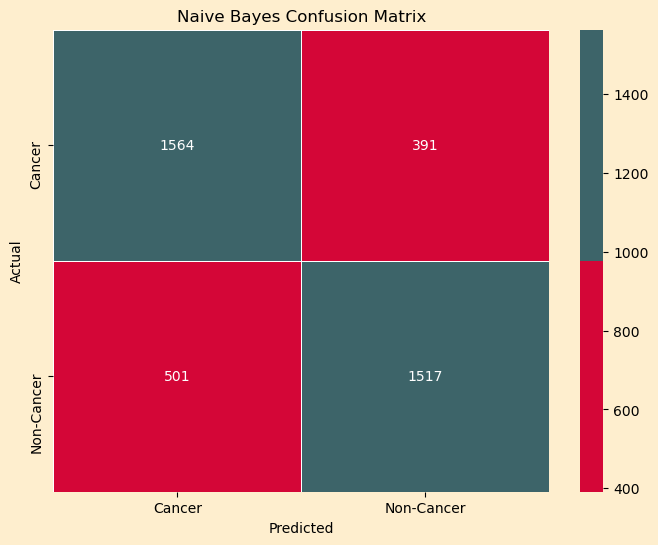

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap


# Confusion Matrix (for Multiclass)
# Create confusion matrix by grouping by label and prediction
confusion_matrix = predictions.groupBy("label", "prediction").count().toPandas()
print(confusion_matrix)

confusion_matrix['label'] = confusion_matrix['label'].replace({0: "Cancer", 1: "Non-Cancer"})
confusion_matrix['prediction'] = confusion_matrix['prediction'].replace({0: "Cancer", 1: "Non-Cancer"})

# Show the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix)

# Optionally, to display it as a matrix format:
confusion_matrix_pivot = confusion_matrix.pivot(index="label", columns="prediction", values="count").fillna(0)
print("\nConfusion Matrix (Pivoted):")
print(confusion_matrix_pivot)

custom_colors = ["#d40637", "#3d6469"]
cmap = ListedColormap(custom_colors)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt='g', cmap=cmap, cbar=True, linewidths=0.5)
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.gcf().set_facecolor("#feeece")  # Set figure background color
plt.show()

In [17]:


# Split the data 80-20
train_data, test_data = processed_df.randomSplit([0.8, 0.2], seed=42)

# Train Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Predict
predictions = lr_model.transform(test_data)

# Evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.3f}")




StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 65, 22, Finished, Available, Finished)

Test Accuracy: 0.707


In [18]:
# Weighted Precision (Multiclass)
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Test Precision: {precision:.3f}")

# Weighted Recall (Multiclass)
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Test Recall: {recall:.3f}")

# F1-Score (Multiclass)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"Test F1-Score: {f1_score:.3f}")

# AUC-ROC (For Binary Classification, works for binary classification)
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_roc = evaluator_auc.evaluate(predictions)
print(f"Test AUC-ROC: {auc_roc:.3f}")

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 65, 23, Finished, Available, Finished)

Test Precision: 0.707
Test Recall: 0.707
Test F1-Score: 0.707
Test AUC-ROC: 0.707


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 65, 26, Finished, Available, Finished)

   label  prediction  count
0    0.0         1.0    581
1    0.0         0.0   1374
2    1.0         1.0   1434
3    1.0         0.0    584

Confusion Matrix:
        label  prediction  count
0      Cancer  Non-Cancer    581
1      Cancer      Cancer   1374
2  Non-Cancer  Non-Cancer   1434
3  Non-Cancer      Cancer    584

Confusion Matrix (Pivoted):
prediction  Cancer  Non-Cancer
label                         
Cancer        1374         581
Non-Cancer     584        1434


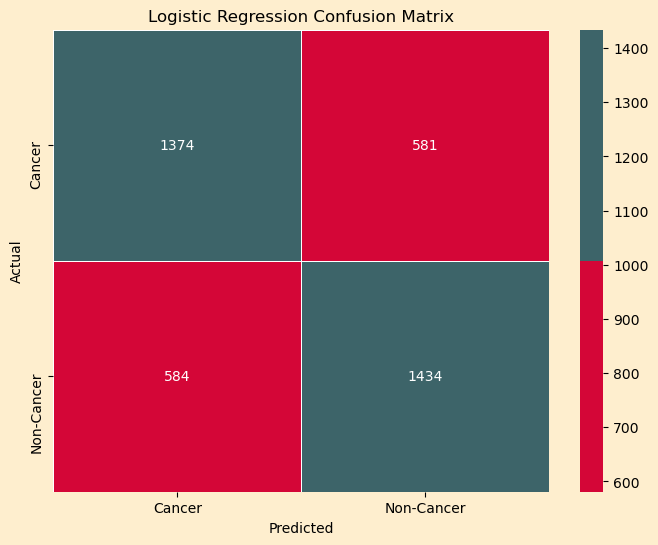

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap


# Confusion Matrix (for Multiclass)
# Create confusion matrix by grouping by label and prediction
confusion_matrix = predictions.groupBy("label", "prediction").count().toPandas()
print(confusion_matrix)

confusion_matrix['label'] = confusion_matrix['label'].replace({0: "Cancer", 1: "Non-Cancer"})
confusion_matrix['prediction'] = confusion_matrix['prediction'].replace({0: "Cancer", 1: "Non-Cancer"})

# Show the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix)

# Optionally, to display it as a matrix format:
confusion_matrix_pivot = confusion_matrix.pivot(index="label", columns="prediction", values="count").fillna(0)
print("\nConfusion Matrix (Pivoted):")
print(confusion_matrix_pivot)

custom_colors = ["#d40637", "#3d6469"]
cmap = ListedColormap(custom_colors)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt='g', cmap=cmap, cbar=True, linewidths=0.5)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.gcf().set_facecolor("#feeece")  # Set figure background color
plt.show()